Updating data.

YahooFinance update of AAPL is not append-only!
Difference between overlap of downloaded and stored:                            open  low  high  close  volume    return
2024-03-18 13:30:00+00:00  0.00  0.0   0.0    0.0     0.0  0.001424
2024-03-19 13:30:00+00:00  0.25  NaN   NaN    NaN     NaN       NaN
YahooFinance(AAPL) update changed last open price: stored value was 174.08999633789062, new value is 174.33999633789062


.

YahooFinance update of AMZN is not append-only!
Difference between overlap of downloaded and stored:                                open  low  high  close  volume    return
2024-03-18 13:30:00+00:00  0.000000  0.0   0.0    0.0     0.0 -0.000057
2024-03-19 13:30:00+00:00 -0.009995  NaN   NaN    NaN     NaN       NaN
YahooFinance(AMZN) update changed last open price: stored value was 174.22999572753906, new value is 174.22000122070312


.

YahooFinance update of GOOG is not append-only!
Difference between overlap of downloaded and stored:                                open  low  high  close  volume    return
2024-03-18 13:30:00+00:00  0.000000  0.0   0.0    0.0     0.0 -0.000134
2024-03-19 13:30:00+00:00 -0.020004  NaN   NaN    NaN     NaN       NaN
YahooFinance(GOOG) update changed last open price: stored value was 149.0, new value is 148.97999572753906


.

YahooFinance update of MSFT is not append-only!
Difference between overlap of downloaded and stored:                                open  low  high  close  volume    return
2024-03-18 13:30:00+00:00  0.000000  0.0   0.0    0.0     0.0 -0.000507
2024-03-19 13:30:00+00:00 -0.210022  NaN   NaN    NaN     NaN       NaN
YahooFinance(MSFT) update changed last open price: stored value was 418.0400085449219, new value is 417.8299865722656




#################################################################
Universe size                                                   5
Initial timestamp                       2020-01-02 14:30:00+00:00
Final timestamp                         2024-03-21 13:30:00+00:00
Number of periods                                            1062
Initial value (USDOLLAR)                                1.000e+06
Final value (USDOLLAR)                                  1.454e+06
Profit (USDOLLAR)                                       4.537e+05
                                                                 
Avg. return (annualized)                                    10.7%
Volatility (annualized)                                     18.9%
Avg. excess return (annualized)                              8.8%
Avg. active return (annualized)                              8.8%
Excess volatility (annualized)                              18.9%
Active volatility (annualized)                              18.9%
        

/Users/edkwang/.pyenv/versions/3.12.2/envs/rsch/lib/python3.12/site-packages/cvxportfolio/result.py:862: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show() # pragma: no cover


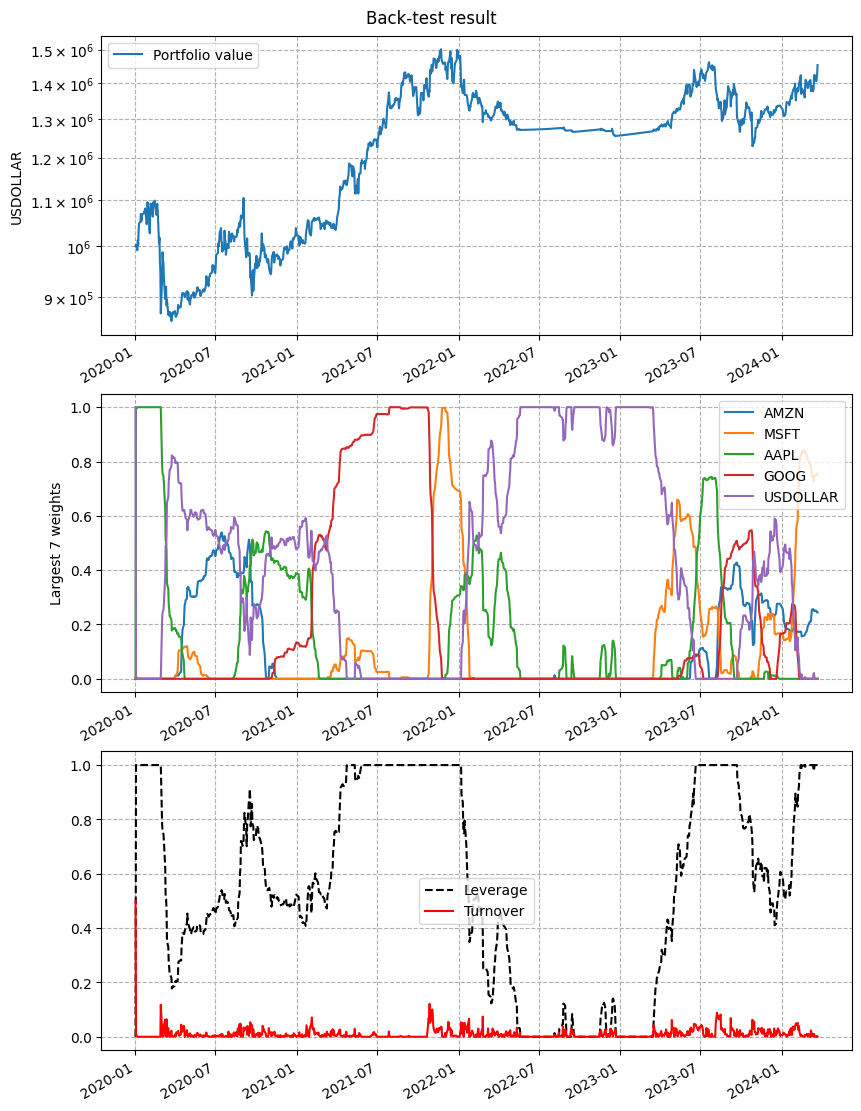

In [1]:
"""REQUIRES cvxportfolio >= 0.4.4.

This example shows how the user can provide custom-made
predictors for expected returns and covariances,
at each point in time of the backtest. These can be
used seamlessly inside a cvxportfolio backtest routine.
"""

import cvxportfolio as cvx


# Here we define a class to forecast expected returns
class WindowMeanReturn:
    """Expected return as mean of recent window of past returns."""

    def __init__(self, window=20):
        self.window = window

    def values_in_time(self, past_returns, **kwargs):
        """This method computes the quantity of interest.

        It has many arguments, we only need to use past_returns
        in this case.

        NOTE: the last column of `past_returns` are the cash returns.
        You need to explicitely skip them otherwise the compiler will
        throw an error.
        """
        return past_returns.iloc[-self.window:, :-1].mean()


# Here we define a class to forecast covariances
class WindowCovariance:
    """Covariance computed on recent window of past returns."""

    def __init__(self, window=20):
        self.window = window

    def values_in_time(self, past_returns, **kwargs):
        """This method computes the quantity of interest.

        It has many arguments, we only need to use past_returns
        in this case.

        NOTE: the last column of `past_returns` are the cash returns.
        You need to explicitely skip them otherwise the compiler will
        throw an error.
        """
        return past_returns.iloc[-self.window:, :-1].cov()


# define the hyperparameters
WINDOWMU = 125
WINDOWSIGMA = 125
GAMMA_RISK = 5
GAMMA_TRADE = 3

# define the policy
policy = cvx.SinglePeriodOptimization(
    objective = cvx.ReturnsForecast(WindowMeanReturn(WINDOWMU))
        - GAMMA_RISK * cvx.FullCovariance(WindowCovariance(WINDOWSIGMA))
        - GAMMA_TRADE * cvx.StocksTransactionCost(),
    constraints = [cvx.LongOnly(), cvx.LeverageLimit(1)]
    )

# define the simulator
simulator = cvx.StockMarketSimulator(['AAPL', 'GOOG', 'MSFT', 'AMZN'])

# backtest
result = simulator.backtest(policy, start_time='2020-01-01')

# show the result
print(result)
result.plot()